# Churn Case Study

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score

from scipy.optimize import minimize

## 1. Introduction

This case study is to predict clients' churn probability based on the collected dataset and to optimize the solution for churn prevention by offering proper discounts while maximizing the future profit of the company.

It proceeds on following order:
- Understand data
- Clean data
- Feature engineering: select major features and add new meaningful features
- Build prediction models
- Evaluate models and select a best performance model with the dataset
- Predict Client's Churn
- Distinguish client where to contact to propose discount or not depending on churn probabiliy
- Calculate optimal amount of discount to propose per client

## 2. Data Understanding and Preparation

In [2]:
# Load training Dataset
df = pd.read_csv("training.csv")
df.head()

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,zero,660.000000,19995.0,0,0,897338.0,False,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,one,317.647059,31477.0,155,15,393396.0,True,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,zero,208.695652,66742.0,0,13,937197.0,False,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,zero,265.017668,40864.0,183,0,986430.0,False,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,one,440.000000,43321.5,200,0,394622.0,True,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE


In [3]:
# Check dataset size
# Our dataset has 11981 rows with 19 columns
df.shape

(11981, 19)

In [4]:
# Check statistic description of dataset
df.describe()

,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,11981.000000,11981.000000,11981.000000,11981.000000,11346.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000
mean,503.625376,47595.943703,80.185460,23.785577,506521.681650,2.070194,2.508639,155.541941,383.495868,7.540356,3.079250,5.972957
std,457.156513,22293.736749,84.587419,26.680037,256808.319571,1.249974,1.120546,47.905580,210.601172,8.768863,1.650221,4.361189
min,0.000000,10032.500000,-2.000000,0.000000,150015.000000,0.000000,1.000000,50.000000,130.000000,0.000000,0.300000,1.000000
25%,181.818182,29367.000000,0.000000,0.000000,268511.250000,1.000000,2.000000,121.000000,217.000000,1.000000,1.900000,2.000000
50%,360.995851,44992.500000,56.000000,15.000000,469775.500000,2.000000,3.000000,149.000000,322.000000,4.000000,2.700000,5.000000
75%,685.714286,65078.000000,171.000000,41.000000,722464.250000,3.000000,4.000000,182.000000,515.000000,13.000000,3.800000,9.000000
max,6600.000000,105355.500000,298.000000,89.000000,999996.000000,7.000000,4.000000,521.000000,899.000000,29.000000,21.000000,15.000000


In [5]:
# Check feature information
# We can check each column's type and where it contains nan value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CUSTOMER_ID                  11981 non-null  object 
 1   COLLEGE                      11981 non-null  object 
 2   DATA                         11981 non-null  float64
 3   INCOME                       11981 non-null  float64
 4   OVERCHARGE                   11981 non-null  int64  
 5   LEFTOVER                     11981 non-null  int64  
 6   HOUSE                        11346 non-null  float64
 7   LESSTHAN600k                 11346 non-null  object 
 8   CHILD                        11981 non-null  int64  
 9   JOB_CLASS                    11981 non-null  int64  
 10  REVENUE                      11981 non-null  float64
 11  HANDSET_PRICE                11981 non-null  int64  
 12  OVER_15MINS_CALLS_PER_MONTH  11981 non-null  int64  
 13  TIME_CLIENT     

In [6]:
# Check unique categories in categorical variables
for i in df.select_dtypes(exclude=['int', 'float']).columns:
    print(f"{i}: {df[i].unique()}")

CUSTOMER_ID: ['C100000' 'C100001' 'C100006' ... 'C115970' 'C115972' 'C115973']
COLLEGE: ['zero' 'one']
LESSTHAN600k: [False True nan]
REPORTED_SATISFACTION: ['very_unsat' 'unsat' 'avg' 'very_sat' 'sat']
REPORTED_USAGE_LEVEL: ['little' 'very_little' 'very_high' 'high' 'avg']
CONSIDERING_CHANGE_OF_PLAN: ['considering' 'actively_looking_into_it' 'never_thought' 'no' 'perhaps']
CHURNED: ['STAY' 'LEAVE']


## 3. Data Analysis

In [7]:
# Check mean value of features depending on whether customers churned or not
df.groupby("CHURNED").agg("mean")

,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
CHURNED,,,,,,,,,,,,
LEAVE,536.061081,52582.809911,104.433738,25.844358,439600.234982,2.072786,2.491417,156.448157,405.595102,9.796979,3.055253,5.898146
STAY,485.008509,44733.671177,66.267867,22.603915,545042.636578,2.068707,2.518523,155.021808,370.811745,6.245139,3.093024,6.015896


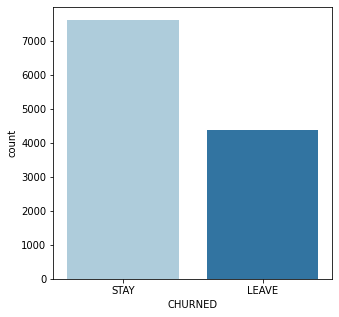

<AxesSubplot:ylabel='CHURNED'>

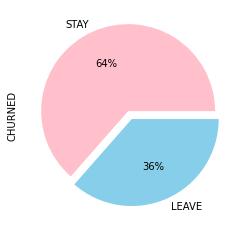

In [8]:
# Dataset imbalance check
# The class ratio is less than 2:1 and we define the dataset is not imbalanced
plt.figure(figsize=(5, 5))
sns.countplot(x=df['CHURNED'], palette="Paired")
plt.show()
df['CHURNED'].value_counts().plot(kind="pie", autopct="%1.0f%%", colors=["pink", "skyblue"], explode=(0.05, 0.05))

In [9]:
# Visulalize box plot and count plot to understand dataset better depending on "CHURNED" class
def box_plot(churn_label, column_list, df):
    f, axes = plt.subplots(4, 3, figsize=(17,15))
    for column, ax in zip(column_list, axes.ravel()):
        sns.boxplot(x=churn_label, y=column, data=df[[churn_label, column]], palette="Paired", ax=ax)
        ax.set_title(column)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    return plt.show()


def count_plot(churn_label, column_list, df):
    f, axes = plt.subplots(2, 3, figsize=(17,13))
    for column, ax in zip(column_list, axes.ravel()):
        sns.countplot(x=column, hue=churn_label, data=df, palette='Paired', ax=ax)
        ax.set_title(column)
    return plt.show()

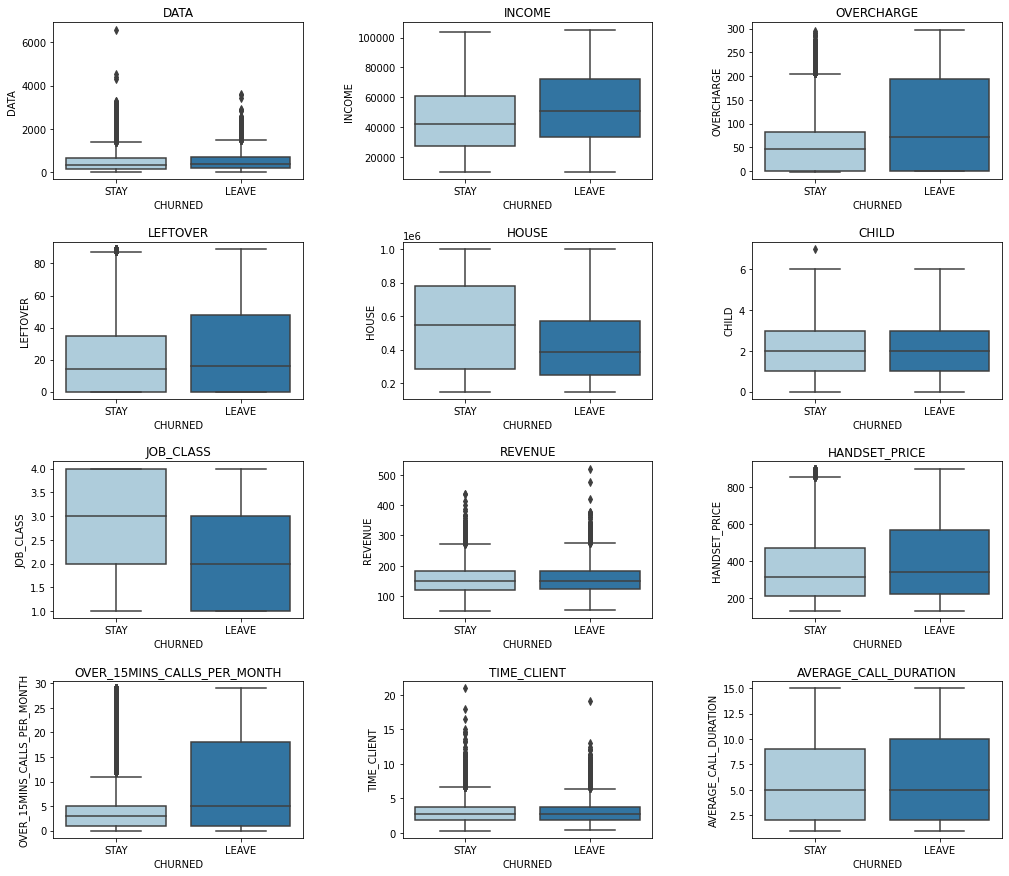

In [10]:
# Numeric Features 
num_col = df.select_dtypes(exclude=['object']).columns
box_plot("CHURNED", num_col, df)

#### Interpret box plots
- The income median of the churned client is a bit higher than the one of staying client
- The house price median of staying clients is higher than the one of churned client
- "JOB_CLASS" is a categorical feature so we will ignore the bar plot of this feature

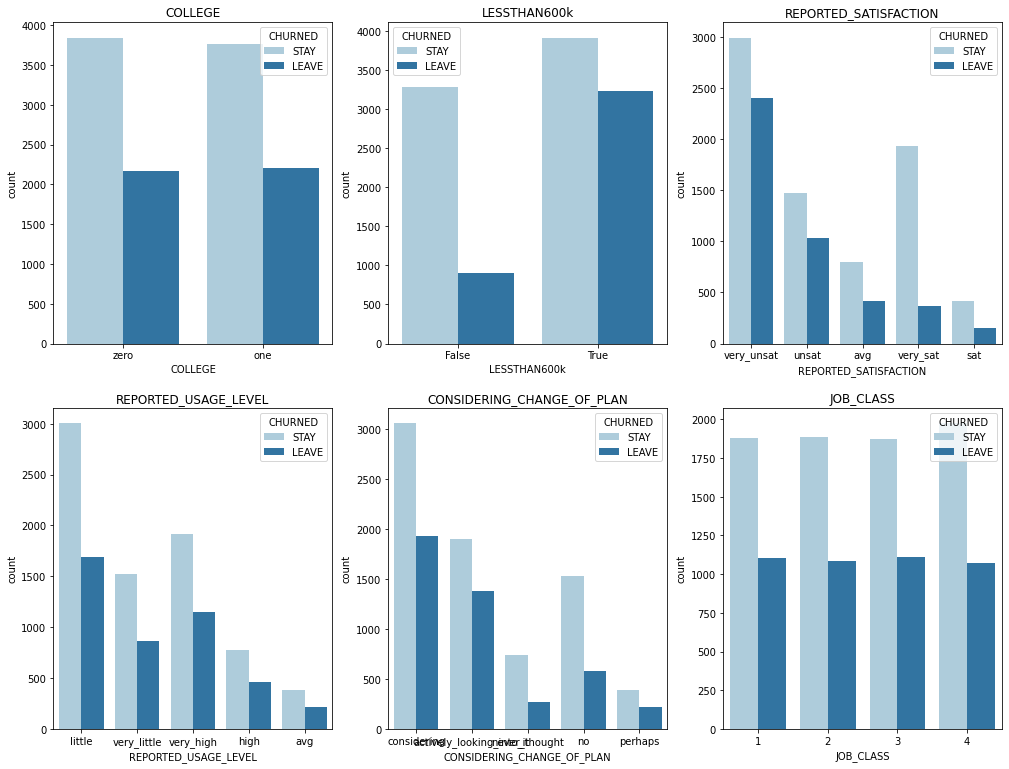

In [11]:
# Categorical Features
cat_col = df.select_dtypes(exclude=['int', 'float'])
cat_col = [col for col in cat_col if col not in ["CUSTOMER_ID", "CHURNED"]]
cat_col.append('JOB_CLASS')
count_plot("CHURNED", cat_col, df)

#### Interpret count plots
- The churn rate of clients who has a house of less than 600k value is much higher
- The clients with unsatisfaction with the company show much higher churn rate
- The clients who have little usage level shows a higher churn rate
- The clients who consider or start to search for another telecom shows a higher churn rate

## 4. Data Cleaning

In [12]:
# Missing value check
df.isnull().sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

In [13]:
# The "HOUSE" and "LESSTHAN600k" columns contain nan value
# To avoid bias, we will drop the rows containing nan value
df = df.dropna()

In [14]:
# When we check box plot, some plots range wide because of outliers
# we need to drop these outliers
# Outlier detection
df_num = df[num_col]
q1 = df_num.quantile(0.25)
q3 = df_num.quantile(0.75)
intr_qr = q3 - q1
((df_num < (q1-1.5*intr_qr)) | (df_num > (q3+1.5*intr_qr))).any()

DATA                            True
INCOME                         False
OVERCHARGE                     False
LEFTOVER                       False
HOUSE                          False
CHILD                          False
JOB_CLASS                      False
REVENUE                         True
HANDSET_PRICE                  False
OVER_15MINS_CALLS_PER_MONTH    False
TIME_CLIENT                     True
AVERAGE_CALL_DURATION          False
dtype: bool

In [15]:
# Outlier Removal
outlier_col = ['DATA', 'REVENUE', 'TIME_CLIENT']
q1 = df[outlier_col].quantile(0.25)
q3 = df[outlier_col].quantile(0.75)
intr_qr = q3 - q1
df = df[~((df[outlier_col] < (q1-1.5*intr_qr)) | (df[outlier_col] > (q3+1.5*intr_qr))).any(axis=1)]

## 5. Feature Engineering

In [16]:
# Exclude "CUSTOMER_ID" that is useless for training
df = df.drop('CUSTOMER_ID', axis=1)

In [17]:
# Generate new feature by sum "REVENUE" and "OVERCHARGE" price
df["TOTAL_REVENUE"] = df.apply(lambda x: x["REVENUE"]+x["OVERCHARGE"], axis=1)

<AxesSubplot:xlabel='CHURNED', ylabel='TOTAL_REVENUE'>

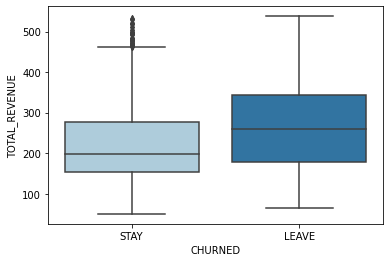

In [18]:
# Check box plot of the new feature
# the box plot of the "REVENUE" feature showed no difference between "CHURNED" classes
# but with the new feature "TOTAL_REVENUE"
# we can check that the client paid more phone bill left company
sns.boxplot(x="CHURNED", y="TOTAL_REVENUE", data=df[["CHURNED", "TOTAL_REVENUE"]], palette="Paired")

In [19]:
# Drop previous features that have high correlation with new feature
df = df.drop(['REVENUE', 'OVERCHARGE'], axis=1)

We need to encode some features to make data manipulation easier
1. No change
- CUSTOMER_ID: identification value
- CHILD: ordinal categorical value
- JOB_CLASS: ordinal categorical value
2. One-Hot encoding
- COLLEGE: one or zero
- LESSTHAN600k: True or False
- CHURNED: LEAVE or STAY
3. Ordinal Encoding
- REPORTED_SATISFACTION: ordinal categorical value
- REPORTED_USAGE_LEVEL: ordinal categoric value
- CONSIDERING_CHANGE_OF_PLAN: ordinal categoric value
4. Scaling
- DATA
- INCOME
- OVERCHARGE
- LEFTOVER
- HOUSE
- REVENUE
- HANDSET_PRICE
- OVER_15MINS_CALLS_PER_MONTH
- TIME_CLIENT
- AVERAGE_CALL_DURATION

In [20]:
# Min-Max-Scaler: range of 0 and 1
mms = MinMaxScaler()

In [21]:
# One-Hot encoding
df['COLLEGE'] = df['COLLEGE'].map({'one': 1, 'zero': 0})
df['LESSTHAN600k'] = df['LESSTHAN600k'].map({True: 1, False: 0})
df['CHURNED'] = df['CHURNED'].map({'LEAVE': 1, 'STAY': 0})
# Ordinal Encoding
df['REPORTED_SATISFACTION'] = df['REPORTED_SATISFACTION'].map({'very_unsat' : 0, 'unsat' : 1, 'avg' : 2, 'very_sat':3, 'sat':4})
df['REPORTED_USAGE_LEVEL'] = df['REPORTED_USAGE_LEVEL'].map({'very_little' : 0, 'little' : 1, 'avg' : 2, 'high' : 3, 'very_high' : 4})
df['CONSIDERING_CHANGE_OF_PLAN'] = df['CONSIDERING_CHANGE_OF_PLAN'].map({'never_thought' : 0, 'no' : 1, 'perhaps' : 2, 'considering' : 3, 'actively_looking_into_it' : 4})
# Scaling
#features = ['DATA', 'INCOME', 'OVERCHARGE', 'LEFTOVER', 'HOUSE', 'REVENUE', 'HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT', 'AVERAGE_CALL_DURATION']
features = ['DATA', 'INCOME', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT', 'AVERAGE_CALL_DURATION', 'TOTAL_REVENUE']
df_features = pd.DataFrame(df, columns=features)
df_other_features = df.drop(columns=features)
scaled_features = mms.fit_transform(df_features)
df_scaled_features = pd.DataFrame(scaled_features, columns=features, index=df_other_features.index)
df = pd.concat([df_other_features, df_scaled_features], axis=1)

In [22]:
df

,COLLEGE,LESSTHAN600k,CHILD,JOB_CLASS,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED,DATA,INCOME,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,TOTAL_REVENUE
0,0,0,4,3,0,1,3,0,0.459412,0.104513,0.000000,0.879223,0.032510,0.034483,0.142857,1.000000,0.225410
1,1,1,0,1,1,1,3,1,0.221107,0.224967,0.168539,0.286337,0.149545,0.931034,0.380952,0.214286,0.420082
2,0,0,4,2,2,0,3,0,0.145269,0.594919,0.146067,0.926117,0.472042,0.689655,0.365079,0.214286,0.157787
3,0,0,3,3,1,4,3,1,0.184473,0.323442,0.000000,0.984040,0.338101,0.448276,0.349206,0.785714,0.448770
4,1,1,2,3,0,1,4,1,0.306275,0.349223,0.000000,0.287779,0.058518,0.620690,0.333333,0.642857,0.465164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,1,1,0,4,2,1,4,0,0.577597,0.320327,0.078652,0.363194,0.227568,0.172414,0.571429,0.214286,0.243852
11977,0,1,3,1,1,1,4,1,0.503633,0.681630,0.000000,0.209600,0.624187,0.172414,0.603175,0.857143,0.448770
11978,0,1,3,1,1,1,4,1,0.055686,0.709608,0.898876,0.341128,0.806242,0.034483,0.174603,0.000000,0.090164
11979,0,0,3,1,0,1,3,0,0.054139,0.290570,0.191011,0.759773,0.200260,0.000000,0.222222,0.500000,0.188525


<AxesSubplot:>

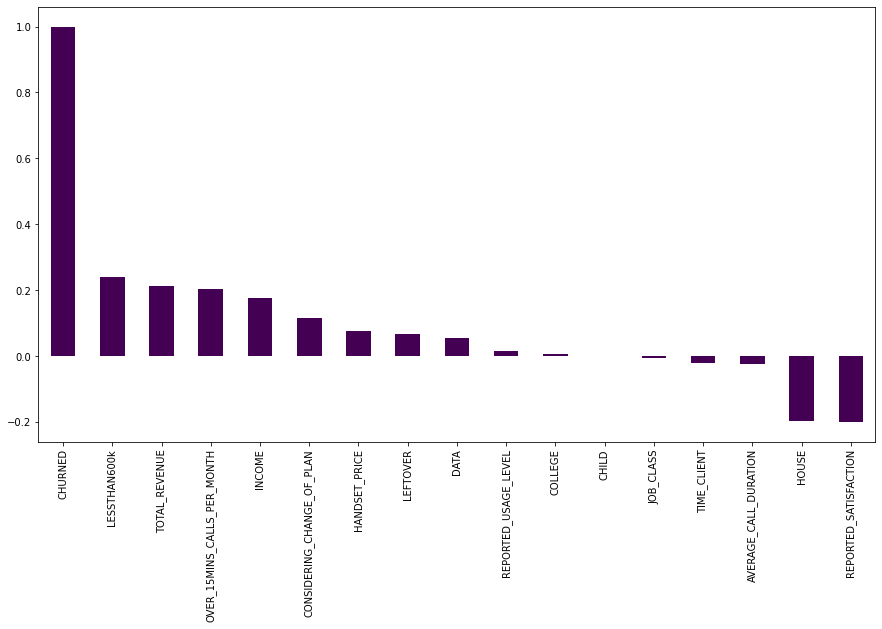

In [23]:
# Correlation of "CHURNED" with other features
plt.figure(figsize=(15,8))
df.corr()['CHURNED'].sort_values(ascending=False).plot(kind='bar', colormap='viridis')

## 6. Train Test dataset split

In [24]:
X = df.drop('CHURNED', axis=1).values
y = df['CHURNED'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7179, 16), (3077, 16), (7179,), (3077,))

## 7. Prediction Models

We will test several models with the dataset and compare their performance.
The models we will test are:
- Logistic regression
- Naive Bayes
- Random Forest Classification
- K-Nearest Neighbor
- Support Vector Classification
- Linear Support Vector Classification
- Decision tree classifier
- XGB Classifier

In [26]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('KN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('L_SVC', LinearSVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('XGB', XGBClassifier()))

In [27]:
# K-fold Cross Validation
def model_performance(X, y, kf_model):
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    confusion_mat = np.zeros((2, 2))
    accuracy, precision, recall, f1 = 0, 0, 0, 0
    for train_idx, test_idx in kfold.split(y):
        kf_X_train, kf_y_train = X[train_idx], y[train_idx]
        kf_X_test, kf_y_test = X[test_idx], y[test_idx]
        kf_model.fit(kf_X_train, kf_y_train)
        kf_y_pred = kf_model.predict(kf_X_test)
        accuracy += accuracy_score(kf_y_test, kf_y_pred)
        scores = score(kf_y_test, kf_y_pred)
        precision += scores[0]
        recall += scores[1]
        f1 += scores[2]
    
    print("Accuracy: ", accuracy/5)
    print("Precision: ", precision/5)
    print("Recall: ", recall/5)
    print("F1: ", f1/5)
    print()

In [28]:
for model_name, model in models:
    print(model_name)
    model_performance(X, y, model)

LR
Accuracy:  0.7262082491020878
Precision:  [0.754401   0.65425365]
Recall:  [0.84763622 0.51117336]
F1:  [0.798243   0.57378492]

NB
Accuracy:  0.7030033844565909
Precision:  [0.75425769 0.59758751]
Recall:  [0.79434354 0.54142757]
F1:  [0.77367685 0.56785249]

RF
Accuracy:  0.7739854946429403
Precision:  [0.79861412 0.71857884]
Recall:  [0.86455543 0.61378714]
F1:  [0.83018968 0.66181405]

KN
Accuracy:  0.6651717937239762
Precision:  [0.7117935 0.5457728]
Recall:  [0.80095372 0.42488148]
F1:  [0.75359994 0.47739695]

SVC
Accuracy:  0.7281579945312656
Precision:  [0.73681326 0.69869507]
Recall:  [0.89415178 0.43418835]
F1:  [0.80780427 0.53526756]

L_SVC
Accuracy:  0.7271830980560997
Precision:  [0.7546448  0.65678212]
Recall:  [0.84927054 0.51095581]
F1:  [0.79910214 0.57459541]

DTC
Accuracy:  0.6913027259084382
Precision:  [0.76274335 0.57051799]
Recall:  [0.75114874 0.58607964]
F1:  [0.75670944 0.57774346]

XGB
Accuracy:  0.7832482704675986
Precision:  [0.81355113 0.7209193 ]
Rec

## 8. Model fitting and selection

Random forest classification and XGB Classifier show good performance among the models. We will compare these two model performances by optimizing the parameters and will select a final model to use for validation dataset prediction.

In [29]:
# Function to show best model performance score and parameters
def best_model(model):
    print("Best Model Performance Score: ", model.best_score_)    
    print("Best Model Parameters: ", model.best_params_)
    
    
def AUC_scores(y, y_pred, y_prob):
    auc_score = roc_auc_score(y, y_pred); 
    fpr_df, tpr_df, _ = roc_curve(y, y_prob); 
    return (auc_score, fpr_df, tpr_df)

In [30]:
# Hyperparameter Tuning the Random Forest
RF_PARAMETERS = {"max_depth":[2, 4, 6, 8],
              'max_features': ['auto', 'sqrt'],
              'min_samples_split': [2, 5, 10],
              "n_estimators":[50, 100, 150, 200]}

RF_model = RandomForestClassifier()
RF_model_gs = GridSearchCV(RF_model, param_grid=RF_PARAMETERS, cv=3, scoring="accuracy")
RF_model_gs.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [31]:
best_model(RF_model_gs)

Best Model Performance Score:  0.7563727538654409
Best Model Parameters:  {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}


In [32]:
RF_y_pred = RF_model_gs.predict(X_test)
print(classification_report(y_test, RF_y_pred, target_names=["STAY", "LEAVE"]))

              precision    recall  f1-score   support

        STAY       0.78      0.86      0.82      1991
       LEAVE       0.69      0.56      0.62      1086

    accuracy                           0.75      3077
   macro avg       0.73      0.71      0.72      3077
weighted avg       0.75      0.75      0.75      3077



In [33]:
# Hyperparameter Tuning the XGB Classifier
XGB_PARAMETERS = {"subsample":[0.5, 0.75, 1],
            "max_depth":[4, 6, 8],
            "min_child_weight":[1, 5, 15],
            "learning_rate":[0.1, 0.01],
            "n_estimators":[100, 200]}

XGB_model = XGBClassifier()
XGB_model_gs = GridSearchCV(XGB_model, param_grid=XGB_PARAMETERS, cv=3, scoring="accuracy")
eval_set = [(X_train, y_train),(X_test, y_test)]
XGB_model_gs.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=0)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [4, 6, 8],
                         'min_child_weight': [1, 5, 15],
                         'n_estimators': [100, 200],
                         'subsample': [0.5, 0.75, 1]},
             scoring='accuracy')

In [34]:
best_model(XGB_model_gs)

Best Model Performance Score:  0.7833960161582394
Best Model Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.75}


In [35]:
XGB_y_pred = XGB_model_gs.predict(X_test)
print(classification_report(y_test, XGB_y_pred, target_names=["STAY", "LEAVE"]))

              precision    recall  f1-score   support

        STAY       0.81      0.86      0.84      1991
       LEAVE       0.72      0.63      0.67      1086

    accuracy                           0.78      3077
   macro avg       0.76      0.75      0.75      3077
weighted avg       0.78      0.78      0.78      3077



In [36]:
xgb_model = XGBClassifier(n_estimators=200, subsample=0.75, learning_rate=0.1, max_depth=4, min_child_weight=5)
xgb_model.fit(X_train,y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_prob = xgb_model.predict_proba(X_test)
auc_XGB, fpr_XGB, tpr_XGB = AUC_scores(y_test, xgb_y_pred, xgb_y_prob[:,1])

rf_model = RandomForestClassifier(max_depth=8, max_features='auto', min_samples_split=5, n_estimators=50)
rf_model.fit(X_train,y_train)
rf_y_pred = rf_model.predict(X_test)
rf_y_prob = rf_model.predict_proba(X_test)
auc_RF, fpr_RF, tpr_RF = AUC_scores(y_test, rf_y_pred, rf_y_prob[:,1])

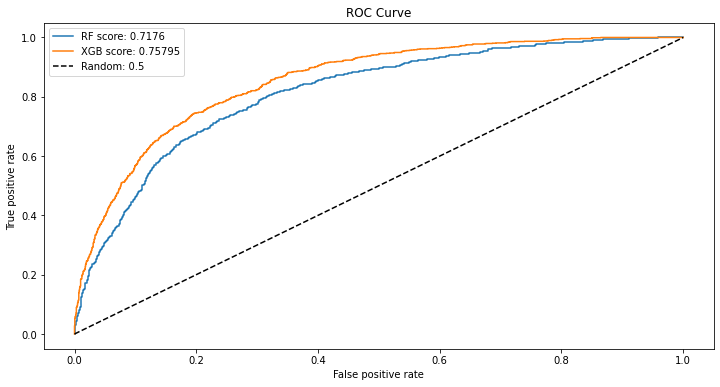

In [37]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## 9. Model Evaluation 

In [38]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, model, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["STAY", "LEAVE"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{model_name} - Confusion Matrix')
    plt.show()
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["STAY", "LEAVE"], cmap=plt.cm.Blues, normalize='true', ax=ax)
    ax.set_title(f'{model_name} - Confusion Matrix (norm.)')
    plt.show()
    print(f'Train Accuracy Score: {model.score(X_train, y_train)}')
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')
    return print("")


def ROC_curve_plot(X_test, y_test, y_prob, model_name):
    y_prob = y_prob[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True model_name Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.show()
    print(f'AUC Score (ROC): {roc_auc_score(y_test, y_prob)}\n')
    return print("")

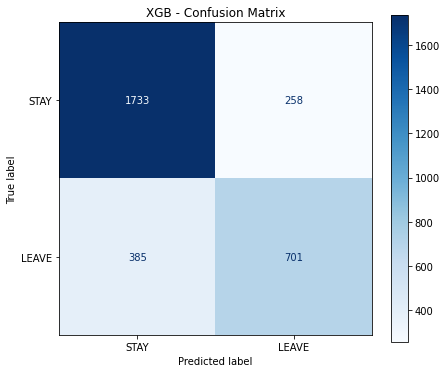

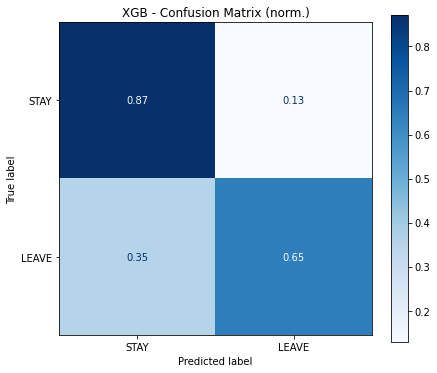

Train Accuracy Score: 0.8634907368714305
Test Accuracy Score: 0.7910302242443938



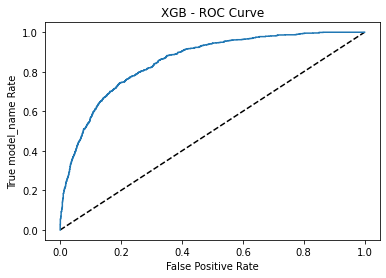

AUC Score (ROC): 0.8541399002694445




In [39]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, xgb_model, xgb_y_pred, "XGB")
ROC_curve_plot(X_test, y_test, xgb_y_prob, "XGB")

In [67]:
# CHURN predict samples
prediction = xgb_model.predict(X_test)
pre_rt = xgb_model.predict_proba(X_test)
res = {1:'Predict to Churn', 0:'Predict to not Churn'}
res_real = {1:'Churned', 0:'Not churned'}
for i in range(10):
    print ("Predicted Churn Label : {}" .format(prediction[i]))
    print ("Meaning : {}" .format(res.get(prediction[i])))
    print ("Not Churn Prob : {:.2f} %" .format(pre_rt[i][0] * 100))
    print ("Churn Prob : {:.2f} %" .format(pre_rt[i][1] * 100))
    print ("Whether Real Churn : {}" .format(res_real.get(y_test[i].item())))
    print ()

Predicted Churn Label : 0
Meaning : Predict to not Churn
Not Churn Prob : 88.27 %
Churn Prob : 11.73 %
Whether Real Churn : Not churned

Predicted Churn Label : 1
Meaning : Predict to Churn
Not Churn Prob : 5.26 %
Churn Prob : 94.74 %
Whether Real Churn : Churned

Predicted Churn Label : 0
Meaning : Predict to not Churn
Not Churn Prob : 79.34 %
Churn Prob : 20.66 %
Whether Real Churn : Not churned

Predicted Churn Label : 1
Meaning : Predict to Churn
Not Churn Prob : 31.73 %
Churn Prob : 68.27 %
Whether Real Churn : Churned

Predicted Churn Label : 0
Meaning : Predict to not Churn
Not Churn Prob : 78.41 %
Churn Prob : 21.59 %
Whether Real Churn : Not churned

Predicted Churn Label : 1
Meaning : Predict to Churn
Not Churn Prob : 12.98 %
Churn Prob : 87.02 %
Whether Real Churn : Churned

Predicted Churn Label : 1
Meaning : Predict to Churn
Not Churn Prob : 29.17 %
Churn Prob : 70.83 %
Whether Real Churn : Churned

Predicted Churn Label : 1
Meaning : Predict to Churn
Not Churn Prob : 46.9

## 10. Predict Validation dataset

In [41]:
# Load validation dataset
val_df = pd.read_csv('validation.csv')
val_df

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,C100002,one,80.000000,45452.5,75,65,342741.0,True,3,1,149.0,300,3,2.2,2,unsat,little,considering
1,C100003,zero,536.842105,40703.5,90,0,215904.0,True,1,1,176.0,384,4,2.4,13,unsat,very_high,actively_looking_into_it
2,C100004,zero,256.578947,35563.0,52,0,341828.0,True,2,3,124.0,371,5,2.3,12,very_sat,avg,considering
3,C100005,zero,466.666667,66072.5,0,8,257222.0,True,3,1,279.0,324,1,2.8,5,very_sat,very_little,actively_looking_into_it
4,C100007,zero,150.000000,21901.5,0,0,800811.0,False,1,3,128.0,164,1,1.5,12,avg,very_high,perhaps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,C115959,one,960.000000,52783.5,0,0,822669.0,False,4,1,168.0,465,0,2.2,9,avg,very_high,never_thought
3989,C115961,zero,540.609137,58424.0,224,7,429682.0,True,2,2,213.0,195,17,5.1,4,sat,little,considering
3990,C115962,zero,102.762431,38030.5,235,57,612910.0,False,4,1,115.0,140,12,2.1,1,very_sat,high,considering
3991,C115969,one,1200.000000,62203.0,70,0,820709.0,False,2,2,146.0,879,3,6.8,12,very_unsat,little,considering


In [42]:
val_df.isnull().sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          199
LESSTHAN600k                   199
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
dtype: int64

In [43]:
val_df["TOTAL_REVENUE"] = val_df.apply(lambda x: x["REVENUE"]+x["OVERCHARGE"], axis=1)
val_df = val_df.drop(['REVENUE', 'OVERCHARGE'], axis=1)

In [44]:
# keep original total value for solution optimization
TOTAL_REVENUE = val_df["TOTAL_REVENUE"]

In [45]:
val_df['COLLEGE'] = val_df['COLLEGE'].map({'one': 1, 'zero': 0})
val_df['LESSTHAN600k'] = val_df['LESSTHAN600k'].map({True: 1, False: 0})
val_df['REPORTED_SATISFACTION'] = val_df['REPORTED_SATISFACTION'].map({'very_unsat' : 0, 'unsat' : 1, 'avg' : 2, 'very_sat':3, 'sat':4})
val_df['REPORTED_USAGE_LEVEL'] = val_df['REPORTED_USAGE_LEVEL'].map({'very_little' : 0, 'little' : 1, 'avg' : 2, 'high' : 3, 'very_high' : 4})
val_df['CONSIDERING_CHANGE_OF_PLAN'] = val_df['CONSIDERING_CHANGE_OF_PLAN'].map({'never_thought' : 0, 'no' : 1, 'perhaps' : 2, 'considering' : 3, 'actively_looking_into_it' : 4})
features = ['DATA', 'INCOME', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT', 'AVERAGE_CALL_DURATION', 'TOTAL_REVENUE']
val_df_features = pd.DataFrame(val_df, columns=features)
val_df_other_features = val_df.drop(columns=features)
val_scaled_features = mms.transform(val_df_features)
val_scaled_features = pd.DataFrame(val_scaled_features, columns=features, index=val_df_other_features.index)
val_df = pd.concat([val_df_other_features, val_scaled_features], axis=1)

In [46]:
val_df

,CUSTOMER_ID,COLLEGE,LESSTHAN600k,CHILD,JOB_CLASS,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,DATA,INCOME,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,TOTAL_REVENUE
0,C100002,1,1.0,3,1,1,1,3,0.055686,0.371579,0.730337,0.226742,0.221066,0.103448,0.301587,0.071429,0.356557
1,C100003,0,1.0,1,1,1,4,4,0.373684,0.321759,0.000000,0.077518,0.330299,0.137931,0.333333,0.857143,0.442623
2,C100004,0,1.0,2,3,3,2,3,0.178599,0.267831,0.000000,0.225667,0.313394,0.172414,0.317460,0.785714,0.258197
3,C100005,0,1.0,3,1,3,0,4,0.324837,0.587896,0.089888,0.126129,0.252276,0.034483,0.396825,0.285714,0.469262
4,C100007,0,0.0,1,3,2,4,2,0.104412,0.124513,0.000000,0.765659,0.044213,0.034483,0.190476,0.785714,0.159836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,C115959,1,0.0,4,1,2,4,0,0.668235,0.448486,0.000000,0.791375,0.435631,0.000000,0.301587,0.571429,0.241803
3989,C115961,0,1.0,2,2,4,1,3,0.376306,0.507658,0.078652,0.329027,0.084525,0.586207,0.761905,0.214286,0.793033
3990,C115962,0,0.0,4,1,3,3,3,0.071531,0.293717,0.640449,0.544595,0.013004,0.413793,0.285714,0.000000,0.614754
3991,C115969,1,0.0,2,2,0,1,3,0.835294,0.547302,0.000000,0.789069,0.973992,0.103448,1.031746,0.785714,0.340164


In [47]:
# predict clients' churn
val_df_tmp = val_df.loc[:, val_df.columns != 'CUSTOMER_ID']
churn_label = xgb_model.predict(val_df_tmp)
churn_pro = xgb_model.predict_proba(val_df_tmp)
val_df["CHURN_PROBABILITY"] = [cp[1] for cp in churn_pro]
val_df["CHURN_LABEL"] = churn_label

In [48]:
val_df

,CUSTOMER_ID,COLLEGE,LESSTHAN600k,CHILD,JOB_CLASS,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,DATA,INCOME,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,TOTAL_REVENUE,CHURN_PROBABILITY,CHURN_LABEL
0,C100002,1,1.0,3,1,1,1,3,0.055686,0.371579,0.730337,0.226742,0.221066,0.103448,0.301587,0.071429,0.356557,0.483485,0
1,C100003,0,1.0,1,1,1,4,4,0.373684,0.321759,0.000000,0.077518,0.330299,0.137931,0.333333,0.857143,0.442623,0.516925,1
2,C100004,0,1.0,2,3,3,2,3,0.178599,0.267831,0.000000,0.225667,0.313394,0.172414,0.317460,0.785714,0.258197,0.070773,0
3,C100005,0,1.0,3,1,3,0,4,0.324837,0.587896,0.089888,0.126129,0.252276,0.034483,0.396825,0.285714,0.469262,0.287018,0
4,C100007,0,0.0,1,3,2,4,2,0.104412,0.124513,0.000000,0.765659,0.044213,0.034483,0.190476,0.785714,0.159836,0.007563,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,C115959,1,0.0,4,1,2,4,0,0.668235,0.448486,0.000000,0.791375,0.435631,0.000000,0.301587,0.571429,0.241803,0.298081,0
3989,C115961,0,1.0,2,2,4,1,3,0.376306,0.507658,0.078652,0.329027,0.084525,0.586207,0.761905,0.214286,0.793033,0.828526,1
3990,C115962,0,0.0,4,1,3,3,3,0.071531,0.293717,0.640449,0.544595,0.013004,0.413793,0.285714,0.000000,0.614754,0.274641,0
3991,C115969,1,0.0,2,2,0,1,3,0.835294,0.547302,0.000000,0.789069,0.973992,0.103448,1.031746,0.785714,0.340164,0.195142,0


# 11. Churn Prevention Optimization

Our model predicts whether a client will stay or leave and shows a churn possibility.

The churn prevention solution will be based on the prediction result and the solution should show the business impact that reduces the churn ratio and brings maximum profit to the company.

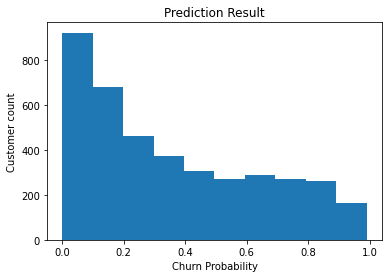

In [49]:
plt.hist(val_df["CHURN_PROBABILITY"])
plt.xlabel('Churn Probability')
plt.ylabel('Customer count')
plt.title('Prediction Result')
plt.show()

The confusion matrix evaluation metrics show four meaningful numbers:
- TP (predicts that a customer would churn when he/she actually would)
- TN (predicts that a customer won’t churn, when he/she actually wouldn’t)
- FN (predicts that a customer won’t churn, but he/she actually would)
- FP (predicts that a customer would churn when he/she actually wouldn’t)

Between these prediction types, what we really need to care about is FN and FP
For the FN type, we make a loss because we couldn't prevent the client's churn

and for the FP type, we waste useless cost for the clients who would stay without a discount.

Therefore our solution has to cover the loss from the two types of error while considering the break-even point.

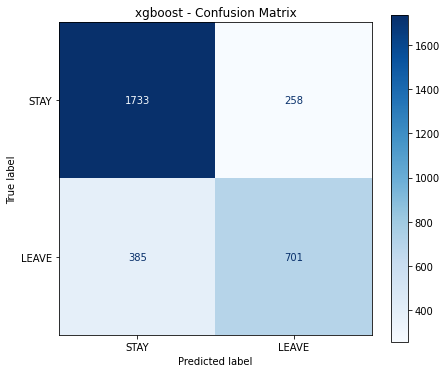

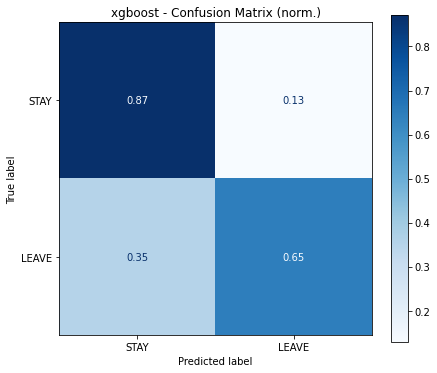

Train Accuracy Score: 0.8634907368714305
Test Accuracy Score: 0.7910302242443938



In [50]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, xgb_model, xgb_y_pred, "xgboost")

If we define the costs per prediction type roughly, the total cost will be:
- TP: 0 euros
- TN: 25 euros (Discount offer, 10% of average client revenue)
- FN: 250 euros (cost for getting new client like marketing expense)
- FP: 25 euros

Total cost = nb_TP * 0 + nb_TN * 25 + nb_FN * 250 + nb_FP * 25

We can think two solution to reduce the total cost for churn prevention.
1. Reduce FN case that costs the most
2. Offer optimal discount amount per client

Let's check probability cutoff about the 1st solution

In [51]:
df_tmp = df.copy()
df_tmp = df_tmp.sample(5000)
churn_label = xgb_model.predict(df_tmp.drop(['CHURNED'], axis=1))
churn_pro = xgb_model.predict_proba(df_tmp.drop(['CHURNED'], axis=1))
df_tmp["CHURN_PROBABILITY"] = [cp[1] for cp in churn_pro]
df_tmp["CHURN_LABEL"] = churn_label

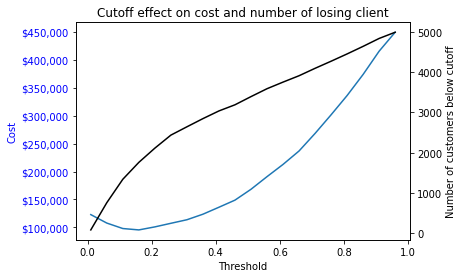

Cost is minimized near a cutoff : 0.16000000000000003
Incentive is paid to 3240 customers, for a total outlay of $ 81000


In [52]:
import matplotlib.ticker as ticker
cutoff_list = np.arange(0.01, 1.0, 0.05)
costs, nb_under_cutoff = [], []
TN, TP, FN, FP = 0, 25, 250, 25
for cutoff in cutoff_list:
    crsstb = pd.crosstab(index=df_tmp["CHURNED"], columns=np.where(df_tmp["CHURN_PROBABILITY"]>cutoff, 1, 0))
    if crsstb.shape == (2, 1):
        if crsstb.columns[0] == 0:
            crsstb[1] = 0
        else:
            crsstb[0] = 0
    costs.append(np.sum(np.sum(np.array([[TN, TP], [FN, FP]])*crsstb)))
    nb_under_cutoff.append(np.count_nonzero(np.where(df_tmp["CHURN_PROBABILITY"]<=cutoff, 1, 0)))
costs = np.array(costs)
fig, ax = plt.subplots(1, 1)
plt.plot(cutoff_list, costs)
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelcolor='b')
plt.xlabel('Threshold')
ax.set_ylabel('Cost',color='b')
ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of customers below cutoff')  
ax2.plot(cutoff_list, nb_under_cutoff, color='k')
ax2.tick_params(axis='y', labelcolor='k')
plt.title('Cutoff effect on cost and number of losing client')
plt.show()
dex = np.argmin(costs)
incentives_paid_to = len(df_tmp) - nb_under_cutoff[dex]
print('Cost is minimized near a cutoff :', cutoff_list[dex])
print('Incentive is paid to', incentives_paid_to, 'customers, for a total outlay of $', incentives_paid_to * TP)

The graph shows that there is a possibility to lose many clients if the cutoff is too high(0.8 < th) and finding a proper cutoff point is important to keep as many as clients and reduce the total cost.

### (1) Find optimal cutoff 

      prob  accuracy  sensitivity  specificity
0.00  0.00  0.352941     1.000000     0.000000
0.05  0.05  0.473838     0.995396     0.189352
0.10  0.10  0.573936     0.975138     0.355098
0.15  0.15  0.649009     0.946593     0.486690
0.20  0.20  0.701657     0.914365     0.585635
0.25  0.25  0.731882     0.868324     0.657459
0.30  0.30  0.750081     0.815838     0.714214
0.35  0.35  0.766331     0.779926     0.758915
0.40  0.40  0.782255     0.741252     0.804621
0.45  0.45  0.787780     0.700737     0.835259
0.50  0.50  0.791030     0.645488     0.870417
0.55  0.55  0.785505     0.585635     0.894525
0.60  0.60  0.776406     0.523941     0.914114
0.65  0.65  0.764706     0.452118     0.935208
0.70  0.70  0.754306     0.393186     0.951281
0.75  0.75  0.739357     0.322284     0.966851
0.80  0.80  0.723432     0.259669     0.976394
0.85  0.85  0.706207     0.189687     0.987946
0.90  0.90  0.676633     0.090239     0.996484
0.95  0.95  0.655184     0.023020     1.000000


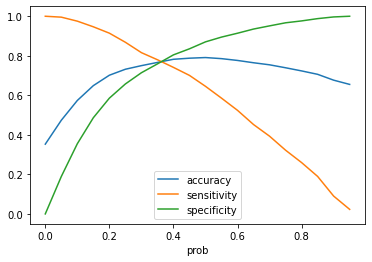

In [53]:
def findOptimalCutoff(y, pred):
    df = pd.DataFrame([y, pred]).T
    df.columns = ['y', 'pred']
    numbers = [float(x)/20 for x in range(20)]
    for i in numbers:
        df[i] = df.pred.map( lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
    for i in numbers:
        cm1 = confusion_matrix(df.y, df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0, 0]+cm1[1, 1])/total1
        specificity = cm1[0, 0]/(cm1[0, 0]+cm1[0, 1])
        sensitivity = cm1[1, 1]/(cm1[1, 0]+cm1[1, 1])
        cutoff_df.loc[i] =[i, accuracy, sensitivity, specificity]
    print(cutoff_df)
    cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
    plt.show()
findOptimalCutoff(y_test, [p[1] for p in xgb_y_prob])

Proper cufoff is 0.4 according to the graph

### (2) Find the client's optimal discount

We assume the total churn prevention program budget is 1% of "TOTAL_REVENUE". 

We will find the optimal discount amount per client and compare the total amount of the optimized program with the situation without any offer and situation when we offer the same amount to every client.

There are multiple variables we need to consider for churn prevention optimization.
- NB_C: number of Clients
- TOTAL: Total prevention program budget
- REVENUE_C: total revenue per client
- CHURN_P: churn probability from model
- CALL: whether the company contact the client for an offer or not (1: yes, 0: no) 
- ACCEPT_P: Possibility whether a client would accept an offer and stay
            1-e^(-CALL*DISCOUNT)
            If there is no discount offer call, there is no possibility to accept an offer
            and if there is much discount, the possibility to accept the offer becomes high
- DISCOUNT: discounts give the customers an incentive to keep coming back to the company again and again

$$Total Cost = \sum_{}(REVENUEC * (1 - CHURNP)) + \sum_{}(ACCEPTP * (CHURNP * REVENUEC - DISCOUNT)) - 10 * CALL$$

In [54]:
NB_C = val_df.shape[0]
TOTAL = 0.01 * np.sum(TOTAL_REVENUE.values)
REVENUE_C = TOTAL_REVENUE.values
CHURN_P = val_df['CHURN_PROBABILITY'].values
print('Total budget is:', '${:,.2f}'.format(TOTAL))
print('Per customer incentive is', '${:,.2f}'.format(TOTAL/NB_C))

Total budget is: $9,394.75
Per customer incentive is $2.35


In [55]:
# Call variable can be changed depending on churn probability and company business decision
# We will think the client has loyalty on company and would stay if the churn probability is under 0.45 
# and the client would leave regardless discount offer amount if the probability is over 0.90 
# it's according to the graphs we check before
CALL = np.ones(NB_C)
NO_CALL = np.union1d(np.where(CHURN_P < 0.45)[0], np.where(CHURN_P > 0.90)[0])
CALL[NO_CALL] = 0
CALL

array([1., 1., 0., ..., 0., 0., 0.])

In [56]:
x0 = [TOTAL/NB_C]*NB_C
def optimization_func(x):
    ACCEPT_P =  [1 - np.exp((-1) * CALL[i] *  x[i]) for i in range(NB_C)]
    ival = [ACCEPT_P[i] * (CALL[i] * REVENUE_C[i] - x[i]) for i in range(NB_C)]
    return -np.sum(ival)
# the revenue after contact and discount has to be positive
bounds = [(0, r-10) for r in REVENUE_C]
res = minimize(optimization_func, x0, bounds=bounds)

In [57]:
res["x"]

array([14.12805072, 18.08409674,  2.35280491, ...,  2.35280491,
        2.35280491,  2.35280491])

In [58]:
def calculate_maximum_profit(x, CALL, CHURN_P, REVENUE_C):
    ACCEPT_P = 1-np.exp(-CALL*(x))
    return np.sum(REVENUE_C*(1-CHURN_P))+np.sum(ACCEPT_P*(ACCEPT_P*REVENUE_C-x))-10*np.sum(CALL)

In [59]:
total_profit_no_program = calculate_maximum_profit(0, CALL, CHURN_P, REVENUE_C)
total_profit_optimal_offer = calculate_maximum_profit(res["x"], CALL, CHURN_P, REVENUE_C)
total_profit_uniform_offer = calculate_maximum_profit((TOTAL/NB_C)*np.ones(NB_C), CALL, CHURN_P, REVENUE_C)

Expected total profit with optimer offer compared to no Solution:  57%
Expected total profit with optimer offer compared to uniform offer Solution:  5%


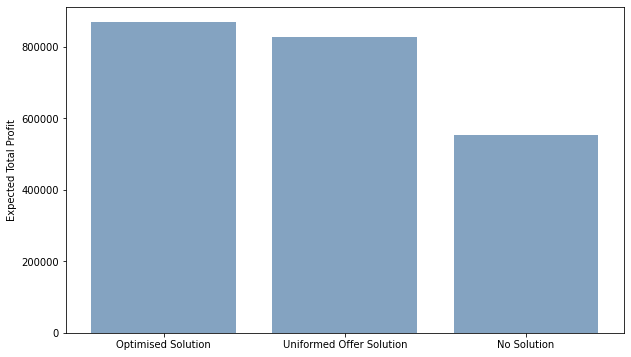

In [60]:
plt.figure(figsize=(10, 6))
data = [total_profit_optimal_offer, total_profit_uniform_offer, total_profit_no_program]
labels = ['Optimised Solution', 'Uniformed Offer Solution', 'No Solution']
plt.xticks(range(len(data)), labels)
plt.ylabel('Expected Total Profit')
plt.bar(range(len(data)), data, color = (0.2, 0.4, 0.6, 0.6))
ax = plt.gca()
fmt = '${x:,.0f}'
print("Expected total profit with optimer offer compared to no Solution:  %.0f%%" %(100*(total_profit_optimal_offer-total_profit_no_program)/total_profit_no_program))
print("Expected total profit with optimer offer compared to uniform offer Solution:  %.0f%%" %(100*(total_profit_optimal_offer-total_profit_uniform_offer)/total_profit_uniform_offer))

The graph verifies that an optimized solution brings higher total profit to the company compared with a uniformed offer solution and without an offer.

## Result

In [61]:
# Labeling with optimal cutoff
val_df['CHURN_LABEL'] = [1 if p > 0.4 else 0 for p in val_df['CHURN_PROBABILITY']]

In [62]:
val_df['DISCOUNT'] = res["x"]
val_df["CLIENT_TO_CONTACT"] = CALL

In [63]:
val_df = val_df[["CUSTOMER_ID", "CHURN_PROBABILITY", "CHURN_LABEL", "CLIENT_TO_CONTACT", "DISCOUNT"]]

In [64]:
val_df['CHURN_LABEL'] = val_df['CHURN_LABEL'].map({1:'LEAVE', 0:'STAY'})
val_df['CLIENT_TO_CONTACT'] = val_df['CLIENT_TO_CONTACT'].map({1: 'YES', 0: 'NO'})
# sort with churn probability
val_df = val_df.sort_values(by=['CHURN_PROBABILITY'], ascending=False)

In [65]:
val_df

,CUSTOMER_ID,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,DISCOUNT
1073,C104230,0.989714,LEAVE,NO,2.352805
1239,C104915,0.987398,LEAVE,NO,2.352805
2253,C109053,0.978518,LEAVE,NO,2.352805
305,C101203,0.977498,LEAVE,NO,2.352805
2174,C108687,0.976486,LEAVE,NO,2.352805
...,...,...,...,...,...
1708,C106844,0.001347,STAY,NO,2.352805
2067,C108242,0.001164,STAY,NO,2.352805
282,C101124,0.001057,STAY,NO,2.352805
3739,C114997,0.000743,STAY,NO,2.352805


In [66]:
# save output dataframe as csv file
val_df.to_csv("output.csv", sep=',')